In [1]:
from imageio import imread
from matplotlib import pyplot as plt
import numpy as np

# 1. Convolutional Filtering 

In [2]:
# Define a map/dict in python
# insert elements (key:value) into it
filters = {}
filters['average'] = np.array([[1.0/9, 1.0/9, 1.0/9],
                               [1.0/9, 1.0/9, 1.0/9],
                               [1.0/9, 1.0/9, 1.0/9]])
filters['blur'] = np.array([[1.0/16, 2.0/16, 1.0/16],
                            [2.0/16, 4.0/16, 2.0/16],
                            [1.0/16, 2.0/16, 1.0/16]])

Raw Image


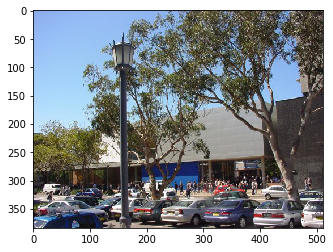

In [3]:
%matplotlib inline
print('Raw Image')
raw_img = imread('parking.jpg')
plt.figure(1)
plt.imshow(raw_img)
plt.show()

In [4]:
def convolution_operation(img, kernel):
    # Define two helper functions via using nested functions
    def covolution_helper(neighbour, kernel):
        # sum of product(element-wise matrix multiplication)
        return np.sum(np.multiply(neighbour, kernel))
    def preprocessing_padding_helper(img, kernel_size):
        pad_size = int(kernel_size / 2)
        # specify the pading for three dimensions
        # ((1,1), (1,1), (0,0)) => 1 padding for left and right, 
        #                          1 padding for top and bottom, 
        #                          no padding for color channels
        padding_3_dims = ((pad_size, pad_size), (pad_size, pad_size), (0, 0))
        img_padded = np.pad(img, padding_3_dims, 'constant', constant_values=0)
        print('*Padding: FROM ', img.shape,' TO ',img_padded.shape)
        return img_padded
    processed_img = np.zeros(img.shape)
    kernel_size = kernel.shape[0]
    img_padded = preprocessing_padding_helper(img, kernel_size)
    # Using 2-for loop to perform matrix operation (updating pixel values)
    for row_idx in range(processed_img.shape[0]):
        for col_idx in range(processed_img.shape[1]):
            # perform convolution for each channel individually and seperately
            #    - Pick a targeting pixel
            #    - Fetch Neighbourhood by slicing operation, whose size matching up with the size of kernel
            #    - Calculate new pixel value via convolution operation
            
            r_neighbour = img_padded[row_idx: row_idx + kernel_size, col_idx: col_idx + kernel_size, 0]
            processed_img[row_idx, col_idx, 0] = max(0, min(255, covolution_helper(r_neighbour, kernel)))
            
            g_neighbour = img_padded[row_idx: row_idx + kernel_size, col_idx: col_idx + kernel_size, 1]
            processed_img[row_idx, col_idx, 1] = max(0, min(255, covolution_helper(g_neighbour, kernel)))
            
            b_neighbour = img_padded[row_idx: row_idx + kernel_size, col_idx: col_idx + kernel_size, 2]
            processed_img[row_idx, col_idx, 2] = max(0, min(255, covolution_helper(b_neighbour, kernel)))
    # Put on constraints: 1. Range[0, 255]  2. Integer
    processed_img = np.uint8(processed_img)   # You can comment off this constraint code to see the effects
    return processed_img

result for convolution with average_filter
*Padding: FROM  (384, 512, 3)  TO  (386, 514, 3)


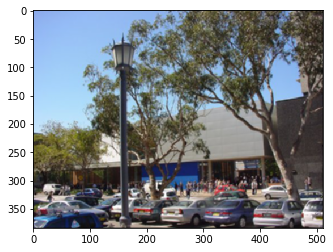

In [5]:
print('result for convolution with average_filter')
plt.figure(2)
plt.imshow(convolution_operation(raw_img, filters['average']))
plt.show()

result for convolution with blur_filter
*Padding: FROM  (384, 512, 3)  TO  (386, 514, 3)


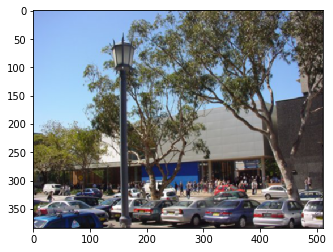

In [6]:
print('result for convolution with blur_filter')
plt.figure(3)
plt.imshow(convolution_operation(raw_img, filters['blur']))
plt.show()

# 2. Histogram Equalization

In [7]:
# Functions Declarations
def apply_histogram_equalization_step1_rgb2gray(img):
    # Step1: Convert to greyscale if required
    img_grey = np.zeros(img.shape[:2])
    for row_idx in range(img.shape[0]):
        for col_idx in range(img.shape[1]):
            rgb_components = img[row_idx][col_idx]
            img_grey[row_idx][col_idx] = int(0.212670 * rgb_components[0] +\
                                             0.715160 * rgb_components[1] +\
                                             0.072169 * rgb_components[2])
    print('Converted Image Shape:', img_grey.shape)
    return img_grey
def apply_histogram_equalization_step2_histogram(img, visualize=False):
    # Step2: Compute the Histogram of the input image. 
    histogram = [0] * 256
    for row in img:
        for pixel in row:
            histogram[int(pixel)] += 1
    if visualize:
        def remove_zero_for_visualization_purpose(histogram):
            x = [] 
            y = []
            for index, count in enumerate(histogram):
                if count == 0:
                    continue
                x.append(index)
                y.append(count)
            return x, y
        x, y = remove_zero_for_visualization_purpose(histogram)
        plt.scatter(x, y)
        plt.xlim(0,255)
        plt.xlabel('PixelValue')
        plt.ylabel('No. Appearance')
        plt.title('Histogram')
        plt.show()
    return histogram
def apply_histogram_equalization_step3_cdf(histogram, visualize=False):
    # Step3: Compute the cumulative distribution function (CDF) of the histogram
    cdf = []
    for index in range(len(histogram)):
        cdf.append(sum(histogram[:index]))
    if visualize:
        plt.plot(cdf)
        plt.xlabel('PixelValue')
        plt.xlim(0,255)
        plt.ylabel('Accumulative Count')
        plt.title('CDF of the histogram')
        plt.show()
    return cdf
def apply_histogram_equalization_step4_rescaling(img, cdf):
    # Step4: Rescale the histogram
    def rescale_function(v):
        return (float(cdf[int(v)] - cdf_min) / (numPixels - cdf_min)) * (L-1)
    cdf_min = min(cdf)
    L = 256.0
    numPixels = img.shape[0] * img.shape[1]
    for row_idx in range(img.shape[0]):
        for col_idx in range(img.shape[1]):
            img[row_idx][col_idx] = rescale_function(img[row_idx][col_idx])
    return np.uint8(img)

Raw Image


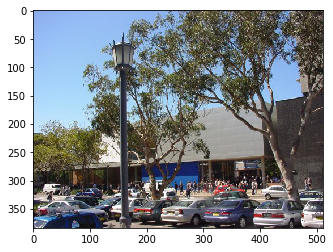

In [8]:
print('Raw Image')
img = imread('parking.jpg')
plt.figure(4)
plt.imshow(img)
plt.show()

### Baseline - Convert RGB to Grayscale, then perform HE

[Step1]: Convert to greyscale if necessary
Converted Image Shape: (384, 512)


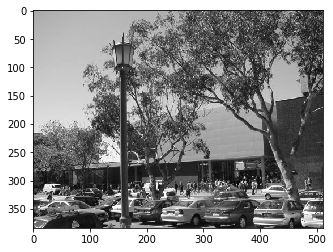

In [9]:
print('[Step1]: Convert to greyscale if necessary')
img_grey = apply_histogram_equalization_step1_rgb2gray(img)
plt.figure(5)
plt.imshow(img_grey, cmap='gray')
plt.show()

[Step2]: Compute the Histogram of the input image


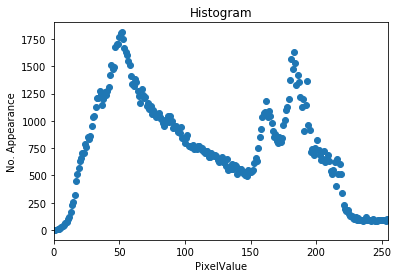

In [10]:
print('[Step2]: Compute the Histogram of the input image')
current_histogram = apply_histogram_equalization_step2_histogram(img_grey, visualize=True)

[Step3]:  Compute the cumulative distribution function (CDF) of the histogram


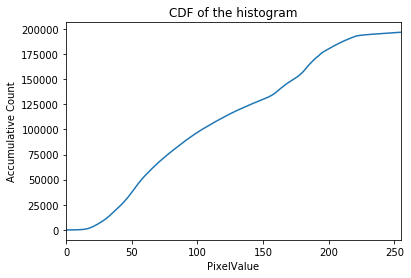

In [11]:
print('[Step3]:  Compute the cumulative distribution function (CDF) of the histogram')
cdf = apply_histogram_equalization_step3_cdf(current_histogram, visualize=True)

In [12]:
print('[Step4]: Rescale the histogram')
updated_img = apply_histogram_equalization_step4_rescaling(img_grey, cdf)

[Step4]: Rescale the histogram


Output Image Performed with HE


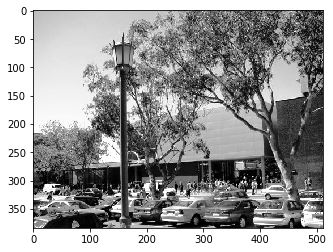

In [13]:
print('Output Image Performed with HE')
plt.figure(6)
plt.imshow(updated_img, cmap='gray')
plt.show()

Rescaled histogram of image performed with HE


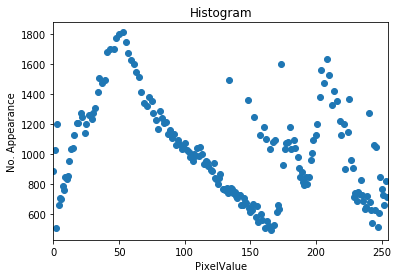

In [14]:
# Now we observe the effect of HE by checking the histogram of updated_img
print('Rescaled histogram of image performed with HE')
current_histogram = apply_histogram_equalization_step2_histogram(updated_img, visualize=True)

### Extension - Perform HE for each color channel individually

Raw Image


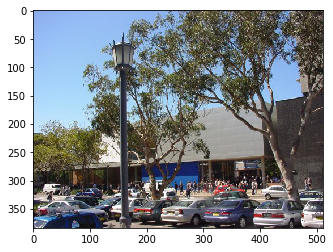

In [15]:
print('Raw Image')
img = imread('parking.jpg')
plt.figure(7)
plt.imshow(img)
plt.show()

In [16]:
# RED Channel
print('Perform HE on Red channel')
img_r = np.copy(img[:,:,0])
raw_histogram_r = apply_histogram_equalization_step2_histogram(img_r, visualize=False)
cdf_r = apply_histogram_equalization_step3_cdf(raw_histogram_r, visualize=False)
img_updated_r = apply_histogram_equalization_step4_rescaling(img_r, cdf_r)
# GREEN Channel
print('Perform HE on Green channel')
img_g = np.copy(img[:,:,1])
raw_histogram_g = apply_histogram_equalization_step2_histogram(img_g, visualize=False)
cdf_g = apply_histogram_equalization_step3_cdf(raw_histogram_g, visualize=False)
img_updated_g = apply_histogram_equalization_step4_rescaling(img_g, cdf_g)
# BLUE Channel
print('Perform HE on Blue channel')
img_b = np.copy(img[:,:,2])
raw_histogram_b = apply_histogram_equalization_step2_histogram(img_b, visualize=False)
cdf_b = apply_histogram_equalization_step3_cdf(raw_histogram_b, visualize=False)
img_updated_b = apply_histogram_equalization_step4_rescaling(img_b, cdf_b)

Perform HE on Red channel
Perform HE on Green channel
Perform HE on Blue channel


Histogram for raw RGB image


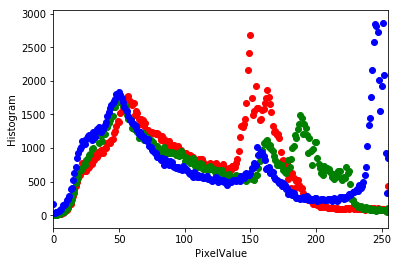

In [17]:
# Histogram of raw image
def plot_histogram_for_rgb_img(histogram_r, histogram_g, histogram_b):
    def remove_zero_for_visualization_purpose(histogram):
        x = [] 
        y = []
        for index, count in enumerate(histogram):
            if count == 0:
                continue
            x.append(index)
            y.append(count)
        return x, y
    plt.figure()
    x_r, y_r = remove_zero_for_visualization_purpose(histogram_r)
    plt.scatter(x_r, y_r, color='r')
    x_g, y_g = remove_zero_for_visualization_purpose(histogram_g)
    plt.scatter(x_g, y_g, color='g')
    x_b, y_b = remove_zero_for_visualization_purpose(histogram_b)
    plt.scatter(x_b, y_b, color='b')
    plt.xlim(0, 255)
    plt.xlabel('PixelValue')
    plt.ylabel('Histogram')
    plt.show()
print('Histogram for raw RGB image')
plot_histogram_for_rgb_img(raw_histogram_r, raw_histogram_g, raw_histogram_b)

Output Image Performed with HE


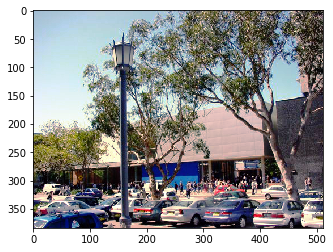

In [18]:
# Combine RGB channels back together
print('Output Image Performed with HE')
img_updated = np.zeros(img.shape)
img_updated[:, :, 0] = img_updated_r[:, :]
img_updated[:, :, 1] = img_updated_g[:, :]
img_updated[:, :, 2] = img_updated_b[:, :]
img_updated = np.uint8(img_updated)
plt.figure(11)
plt.imshow(img_updated)
plt.show()

Rescaled histogram of image performed with HE


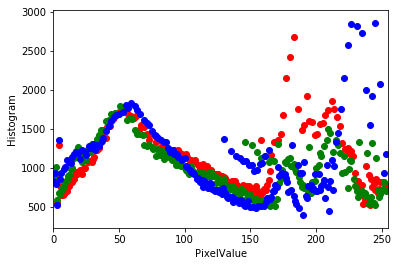

In [19]:
# Histogram of updated image
# Now we observe the effect of HE by checking the histogram of updated_img
print('Rescaled histogram of image performed with HE')
current_histogram_r = apply_histogram_equalization_step2_histogram(img_updated[:,:,0], visualize=False)
current_histogram_g = apply_histogram_equalization_step2_histogram(img_updated[:,:,1], visualize=False)
current_histogram_b = apply_histogram_equalization_step2_histogram(img_updated[:,:,2], visualize=False)
plot_histogram_for_rgb_img(current_histogram_r, current_histogram_g, current_histogram_b)